In [1]:
import pandas as pd
import json
from pathlib import Path
from collections import defaultdict
from itertools import product
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations,permutations
from sklearn.tree import *
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
import random
from math import floor

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
training_path = Path('/Users/karankamath/Desktop/ARC-master/data/training')
test_path = Path('/Users/karankamath/Desktop/ARC-master/data/evaluation')

In [4]:
# Plots the first train and test pairs of a specified task,
# using same color scheme as the ARC app

def plot_result(inp,eoup,oup):

    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 3, figsize=(15,15))

    axs[0].imshow(inp, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Input')

    axs[1].imshow(eoup, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Output')

    axs[2].imshow(oup, cmap=cmap, norm=norm)
    axs[2].axis('off')
    axs[2].set_title('Model prediction')

    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_mats(mats):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, len(mats), figsize=(15,15))

    for i in range(len(mats)):
        axs[i].imshow(mats[i], cmap=cmap, norm=norm)
        axs[i].axis('off')
        axs[i].set_title('Fig: '+str(i))

    plt.rc('grid', linestyle="-", color='white')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [5]:
def getiorc(pair):
    # Extract input and output matrices from the pair
    inp = pair["input"]
    # Return input, output, and dimensions of the input matrix
    return pair["input"], pair["output"], len(inp), len(inp[0])

def getAround(i, j, inp, size=1):
    # Get the dimensions of the input matrix
    r, c = len(inp), len(inp[0])
    # Initialize a list to store the values around the specified cell
    v = []
    # Generate a range of values for the neighborhood size
    sc = [0]
    for q in range(size):
        sc.append(q + 1)
        sc.append(-(q + 1))
    # Iterate over the Cartesian product of sc to get the coordinates of neighboring cells
    for idx, (x, y) in enumerate(product(sc, sc)):
        # Calculate the indices of the neighboring cell
        ii = (i + x)
        jj = (j + y)
        v.append(-1)
        # Check if the neighboring cell indices are within the boundaries of the input matrix
        if (0 <= ii < r) and (0 <= jj < c):
            # Update the value with the value of the neighboring cell
            v[idx] = inp[ii][jj]
    return v

def getDiagonal(i, j, r, c):
    return

def getX(inp, i, j, size):
    # Initialize a list to store features extracted from the input matrix
    z = []
    # Convert input matrix to a NumPy array
    n_inp = np.array(inp)
    # Append the coordinates of the current cell (i, j)
    z.append(i)
    z.append(j)
    # Get the dimensions of the input matrix
    r, c = len(inp), len(inp[0])
    # Append various derived features based on the current cell's position and values
    for m in range(5):
        z.append(i % (m + 1))
        z.append(j % (m + 1))
    z.append(i + j)
    z.append(i * j)
    z.append((i + 1) / (j + 1))
    z.append((j + 1) / (i + 1))
    z.append(r)
    z.append(c)
    # Append the number of unique values in the current row and column
    z.append(len(np.unique(n_inp[i, :])))
    z.append(len(np.unique(n_inp[:, j])))
    # Get the values around the current cell
    arnd = getAround(i, j, inp, size)
    # Append the number of unique values in the neighborhood
    z.append(len(np.unique(arnd)))
    # Extend the feature list with the values of the neighborhood
    z.extend(arnd)
    return z


def getXy(inp, oup, size): # This function just returns the x and y cordinates in a given input/output.
    # Initialize lists to store features (X) and corresponding outputs (Y)
    x = []
    y = []
    # Get the dimensions of the input matrix
    r, c = len(inp), len(inp[0])
    # Iterate over each cell in the input and output matrices
    for i in range(r):
        for j in range(c):
            # Extract features for the current cell and append to X
            x.append(getX(inp, i, j, size))
            # Append the corresponding output value to Y
            y.append(oup[i][j])
    return x, y

def getBkgColor(task_json):
    color_dict = defaultdict(int)

    for pair in task_json['train']:
        inp,oup,r,c = getiorc(pair)
        for i in range(r):
            for j in range(c):
                color_dict[inp[i][j]]+=1
    color = -1
    max_count = 0
    for col,cnt in color_dict.items():
        if(cnt > max_count):
            color = col
            max_count = cnt
    return color

In [6]:
def get_num_colors(inp,oup,bl_cols):
    r,c = len(inp),len(inp[0])
    return

def replace(inp, uni, perm):
    # Create a mapping from unique values in uni to perm
    r_map = {int(c): int(s) for c, s in zip(uni, perm)}
    # Convert input matrix to a list
    rp = np.array(inp).tolist()
    # Replace values in the input matrix based on the mapping
    for i in range(len(rp)):
        for j in range(len(rp[0])):
            if rp[i][j] in r_map:
                rp[i][j] = r_map[rp[i][j]]
    return rp

#It generates augmented data by permuting the colors in the input and output matrices
def augment(inp, oup, bl_cols):
    # Define a string of all possible colors
    cols = "0123456789"
    # Define a list of factorials for permutations
    npr_map = [1, 9, 72, 3024, 15120, 60480, 181440, 362880, 362880]
    # Extract unique values from input matrix and convert them to a string
    uni = "".join([str(x) for x in np.unique(inp).tolist()])
    # Remove blacklisted colors from cols and uni
    for c in bl_cols:
        cols = cols.replace(str(c), "")
        uni = uni.replace(str(c), "")

    # Calculate the expected size of augmented data
    exp_size = len(inp) * len(inp[0]) * npr_map[len(uni)]

    # Calculate a modulo value for downsampling to control data size
    mod = floor(exp_size / 120000)
    mod = 1 if mod == 0 else mod

    result = []
    count = 0
    # Generate combinations and permutations for augmentation
    for comb in combinations(cols, len(uni)):
        for perm in permutations(comb):
            count += 1
            # Downsample the augmentation result
            if count % mod == 0:
                # Replace values in input and output matrices and append to result
                result.append((replace(inp, uni, perm), replace(oup, uni, perm)))
    return result


# applies various flip operations
def get_flips(inp,oup):
    result = []
    n_inp = np.array(inp)
    n_oup = np.array(oup)
    # result.append((np.fliplr(inp).tolist(),np.fliplr(oup).tolist()))
    # result.append((np.rot90(np.fliplr(inp),1).tolist(),np.rot90(np.fliplr(oup),1).tolist()))
    # result.append((np.rot90(np.fliplr(inp),2).tolist(),np.rot90(np.fliplr(oup),2).tolist()))
    # result.append((np.rot90(np.fliplr(inp),3).tolist(),np.rot90(np.fliplr(oup),3).tolist()))
    result.append((np.flipud(inp).tolist(),np.flipud(oup).tolist()))
    result.append((np.rot90(np.flipud(inp),1).tolist(),np.rot90(np.flipud(oup),1).tolist()))
    result.append((np.rot90(np.flipud(inp),2).tolist(),np.rot90(np.flipud(oup),2).tolist()))
    result.append((np.rot90(np.flipud(inp),3).tolist(),np.rot90(np.flipud(oup),3).tolist()))
    result.append((np.fliplr(np.flipud(inp)).tolist(),np.fliplr(np.flipud(oup)).tolist()))
    result.append((np.flipud(np.fliplr(inp)).tolist(),np.flipud(np.fliplr(oup)).tolist()))
    return result


#It generates features (X) and corresponding outputs (Y) for the training data in a given task.
def gettaskxy(task_json,aug,around_size,bl_cols,flip=True):
    X = []
    Y = []
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        tx,ty = getXy(inp,oup,around_size)
        X.extend(tx)
        Y.extend(ty)
        if(flip):
            for ainp,aoup in get_flips(inp,oup):
                tx,ty = getXy(ainp,aoup,around_size)
                X.extend(tx) # Extend function will just add the tx array to the X array.
                Y.extend(ty)
                if(aug):
                    augs = augment(ainp,aoup,bl_cols)
                    for ainp,aoup in augs:
                        tx,ty = getXy(ainp,aoup,around_size)
                        X.extend(tx)
                        Y.extend(ty)
        if(aug):
            augs = augment(inp,oup,bl_cols)
            for ainp,aoup in augs:
                tx,ty = getXy(ainp,aoup,around_size)
                X.extend(tx)
                Y.extend(ty)
    return X,Y

def test_predict(task_json,model,size):
    inp = task_json['test'][0]['input']
    eoup = task_json['test'][0]['output']
    r,c = len(inp),len(inp[0])
    oup = predict(inp,model,size)
    return inp,eoup,oup

def predict(inp,model,size):
    r,c = len(inp),len(inp[0])
    oup = np.zeros([r,c],dtype=int)
    for i in range(r):
        for j in range(c):
            x = getX(inp,i,j,size)
            o = int(model.predict([x])[0])
            o = 0 if o<0 else o
            oup[i][j]=o
    return oup

def submit_predict(task_json,model,size):
    pred_map = {}
    idx=0
    for pair in task_json['test']:
        inp = pair["input"]
        pred = predict(inp,model,size)
        pred_map[idx] = pred.tolist()
        oup = pair["output"]
        idx+=1
        plot_result(inp,oup, pred)
    return pred_map

def dumb_predict(task_json):
    pred_map = {}
    idx=0
    for pair in task_json['test']:
        inp = pair["input"]
        pred_map[idx] = [[0,0],[0,0]]
        idx+=1
    return pred_map

In [7]:
#calculates the loss of a model on the training data of a task
def get_loss(model,task_json,size):
    total = 0
    for pair in task_json['train']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_test_loss(model,task_json,size):
    total = 0
    for pair in task_json['test']:
        inp,oup=pair["input"],pair["output"]
        eoup = predict(inp,model,size)
        total+= np.sum((np.array(oup) != np.array(eoup)))
    return total

def get_a_size(task_json):
    return 4

# This function identifies colors to be blacklisted based on their frequency of occurrence in the training data
def get_bl_cols(task_json):
    result = []
    # Get the background color of the task
    bkg_col = getBkgColor(task_json)
    result.append(bkg_col)
    # Initialize a dictionary to track metadata for each color (input and output)
    met_map = {}
    for i in range(10):
        met_map[i] = [0, 0, 0, 0]  # [num_input, input_cnt, num_output, output_cnt]
    total_ex = 0
    # Iterate over training pairs to collect metadata about input and output colors
    for pair in task_json['train']:
        inp, oup = pair["input"], pair["output"]
        u, uc = np.unique(inp, return_counts=True)
        inp_cnt_map = dict(zip(u, uc))
        u, uc = np.unique(oup, return_counts=True)
        oup_cnt_map = dict(zip(u, uc))
        # Update metadata for each color
        for col, cnt in inp_cnt_map.items():
            met_map[col][0] += 1
            met_map[col][1] += cnt
        for col, cnt in oup_cnt_map.items():
            met_map[col][2] += 1
            met_map[col][3] += cnt
        total_ex += 1
    # Determine which colors should be considered as blacklisted based on metadata
    for col, met in met_map.items():
        num_input, input_cnt, num_output, output_cnt = met
        if (num_input == total_ex or num_output == total_ex):
            result.append(col)
        elif (num_input == 0 and num_output > 0):
            result.append(col)
    # Ensure uniqueness and add background color if necessary
    result = np.unique(result).tolist()
    if (len(result) == 10):
        result.append(bkg_col)
    return np.unique(result).tolist()


In [8]:
#It converts the 2D list into a string.
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

#This function combines predictions from three different models (pm1, pm3, pm5) into a single list of predictions
def combine_preds(tid,pm1,pm3,pm5):
    result = []
    for i in range(len(pm1)):
        tk_s = tid+"_"+str(i)
        str_pred = flattener(pm1[i])+" "+flattener(pm3[i])+" "+flattener(pm5[i])
        #print(tk_s,str_pred)
        result.append([tk_s,str_pred])
    return result
#This function combines predictions from three different models (pm1, pm3, pm5, pm7) into a single list of predictions
def combine_preds1(tid,pm1,pm3,pm5,pm7,pm9):
    result = []
    for i in range(len(pm1)):
        tk_s = tid+"_"+str(i)
        str_pred = flattener(pm1[i])+" "+flattener(pm3[i])+" "+flattener(pm5[i])+" "+flattener(pm7[i])+" "+flattener(pm9[i])
        #print(tk_s,str_pred)
        result.append([tk_s,str_pred])
    return result
#This function combines predictions from three different models (pm1, pm3, pm5, pm7) into a single list of predictions
def combine_preds2(tid,pm1,pm3,pm5,pm7,pm9,pm11,pm13):
    result = []
    for i in range(len(pm1)):
        tk_s = tid+"_"+str(i)
        str_pred = flattener(pm1[i])+" "+flattener(pm3[i])+" "+flattener(pm5[i])+" "+flattener(pm7[i])+" "+flattener(pm9[i])+" "+flattener(pm11[i])+" "+flattener(pm13[i])
        #print(tk_s,str_pred)
        result.append([tk_s,str_pred])
    return result

/Users/karankamath/Desktop/ARC-master/data/evaluation/f0afb749.json
f0afb749
/Users/karankamath/Desktop/ARC-master/data/evaluation/94414823.json
94414823


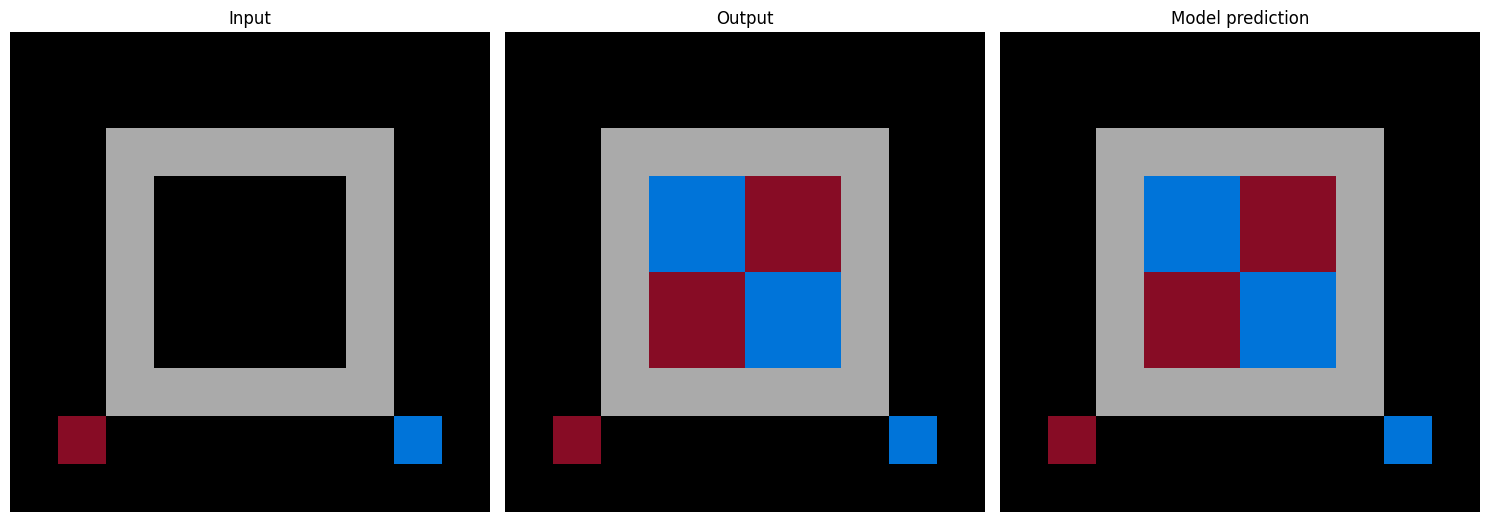

/Users/karankamath/Desktop/ARC-master/data/evaluation/dc2e9a9d.json
dc2e9a9d


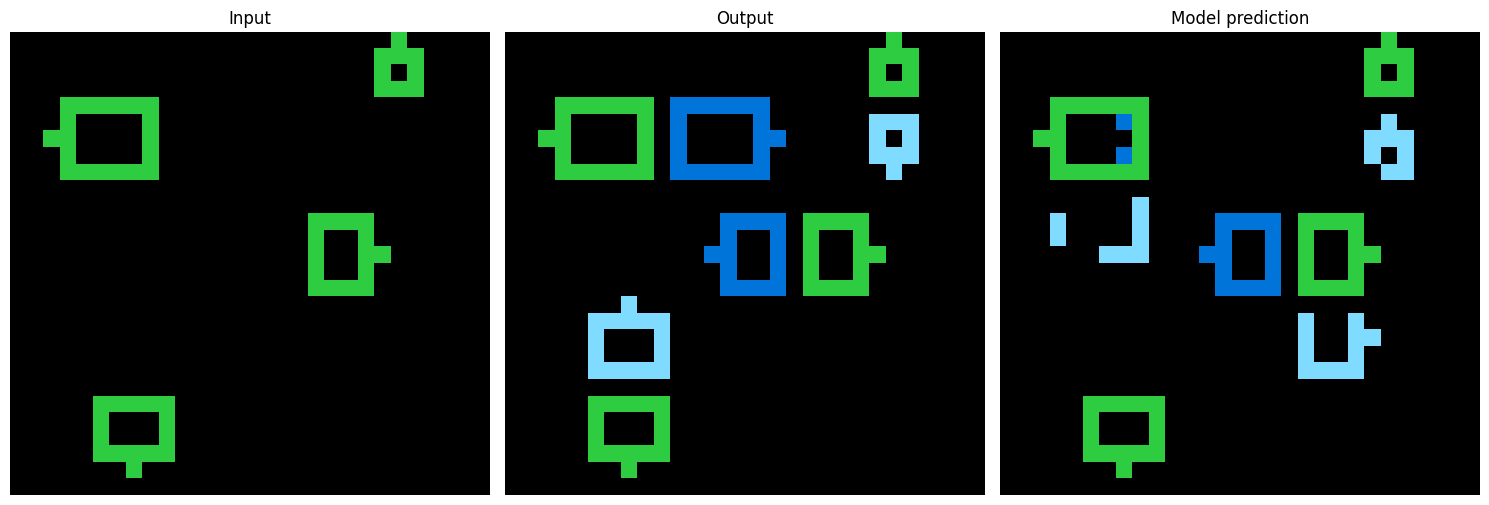

/Users/karankamath/Desktop/ARC-master/data/evaluation/f83cb3f6.json
f83cb3f6


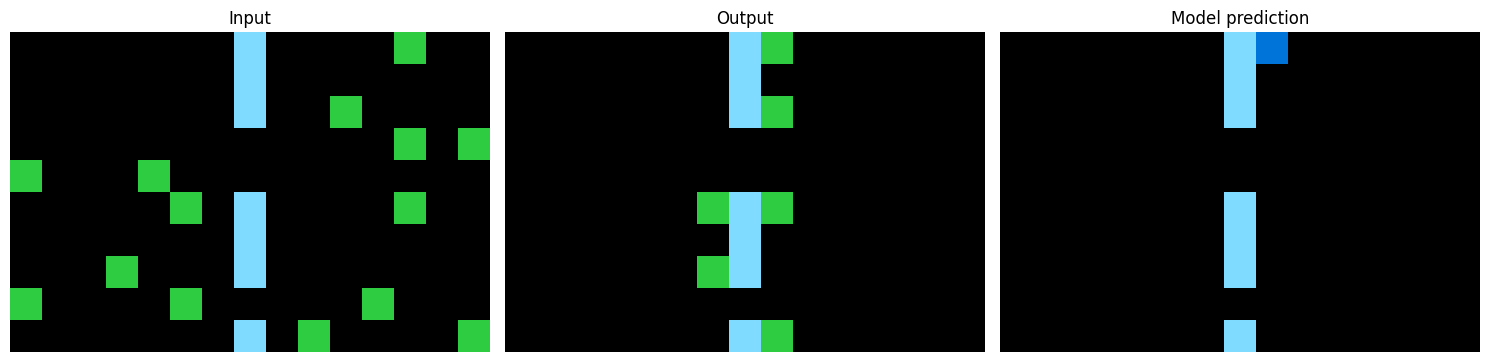

/Users/karankamath/Desktop/ARC-master/data/evaluation/baf41dbf.json
baf41dbf


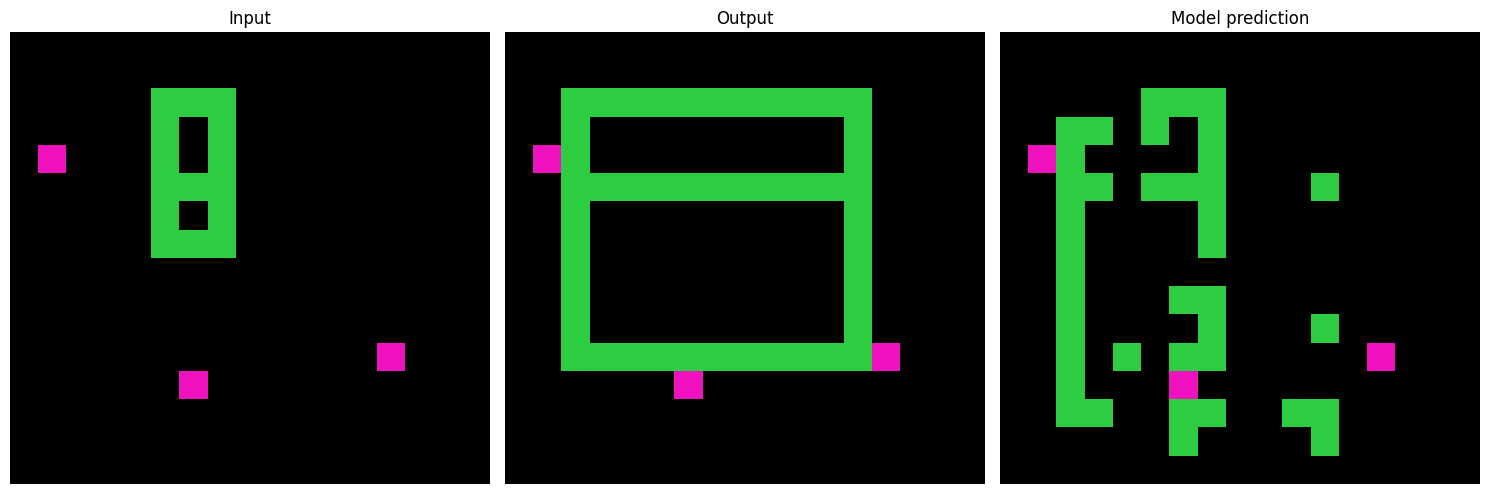

/Users/karankamath/Desktop/ARC-master/data/evaluation/93b4f4b3.json
93b4f4b3
/Users/karankamath/Desktop/ARC-master/data/evaluation/ff72ca3e.json
ff72ca3e


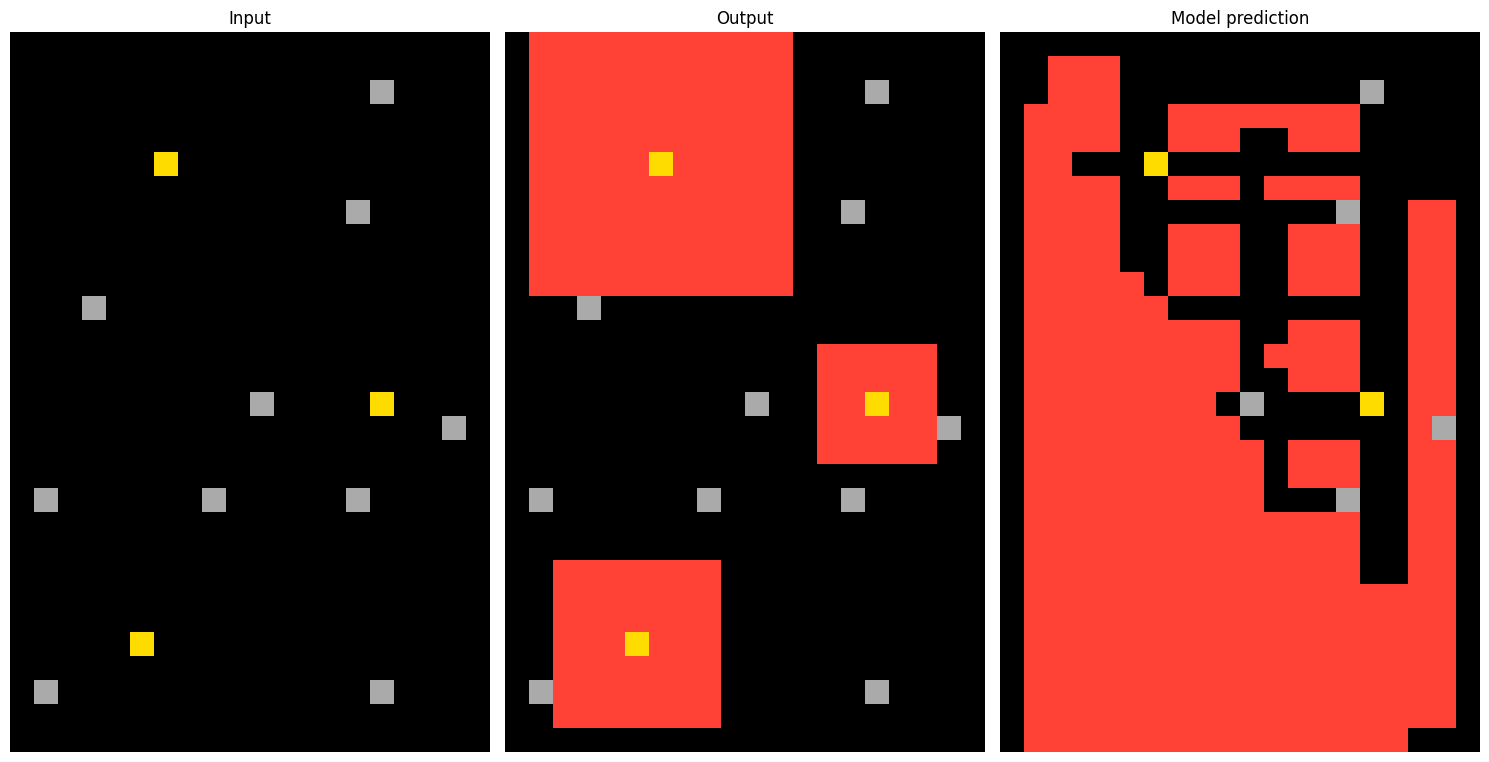

/Users/karankamath/Desktop/ARC-master/data/evaluation/50f325b5.json
50f325b5


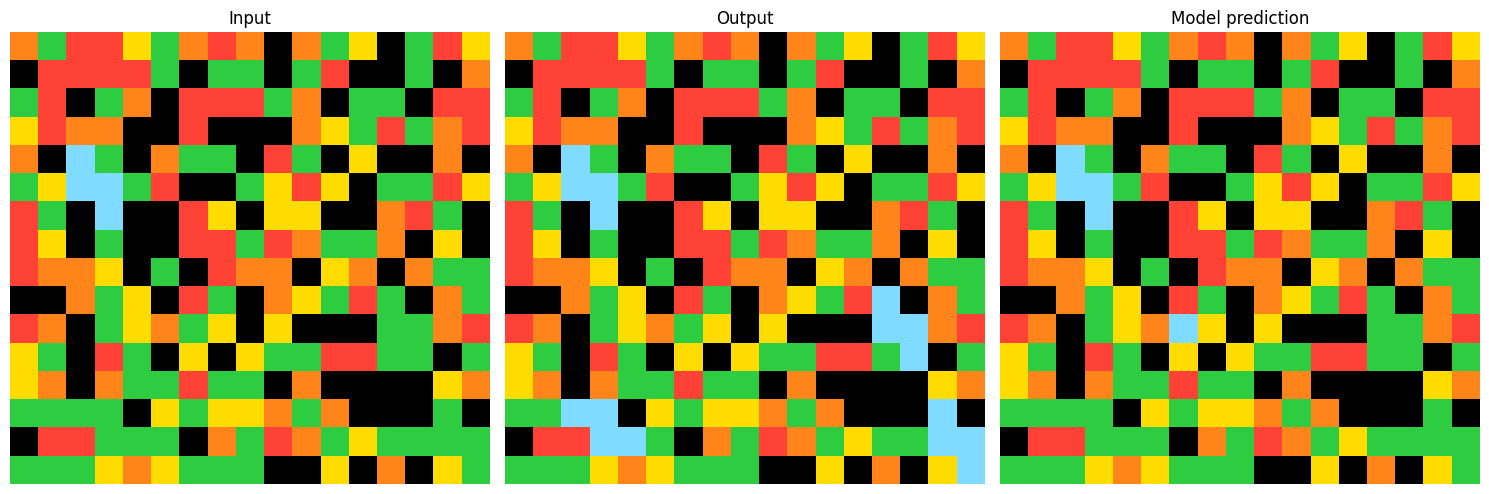

/Users/karankamath/Desktop/ARC-master/data/evaluation/da515329.json
da515329


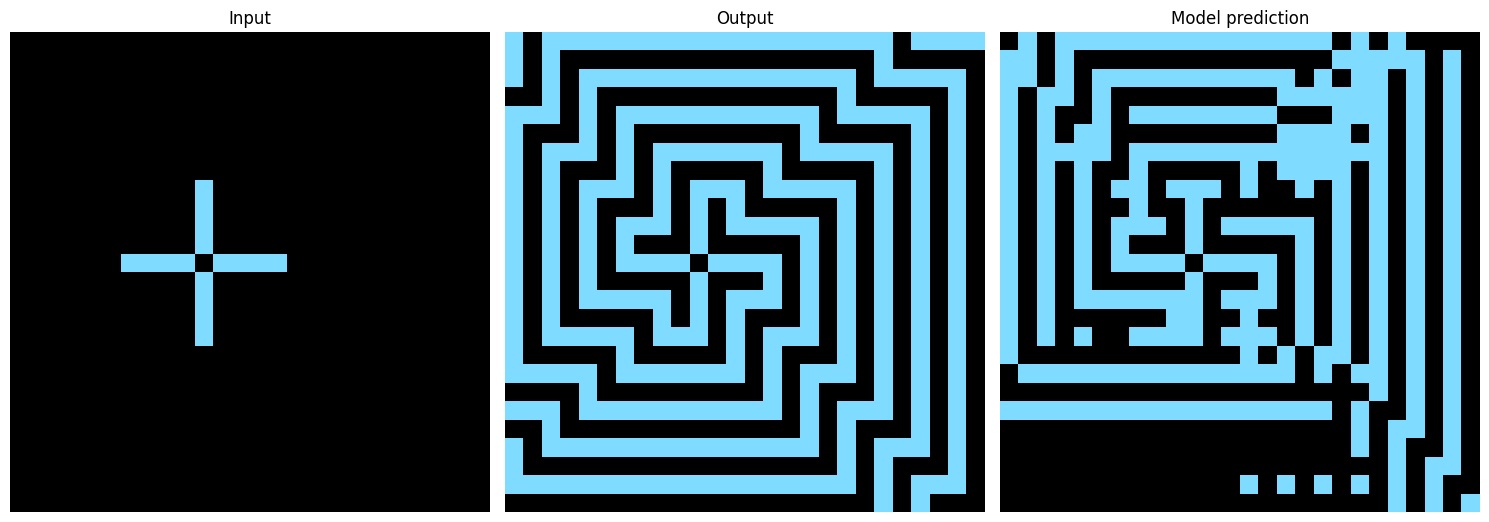

/Users/karankamath/Desktop/ARC-master/data/evaluation/60a26a3e.json
60a26a3e


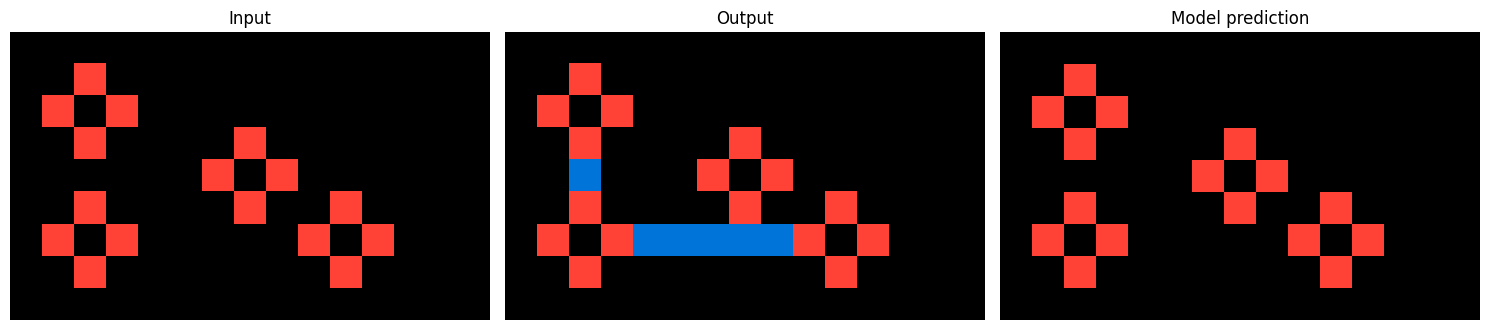

/Users/karankamath/Desktop/ARC-master/data/evaluation/14754a24.json
14754a24


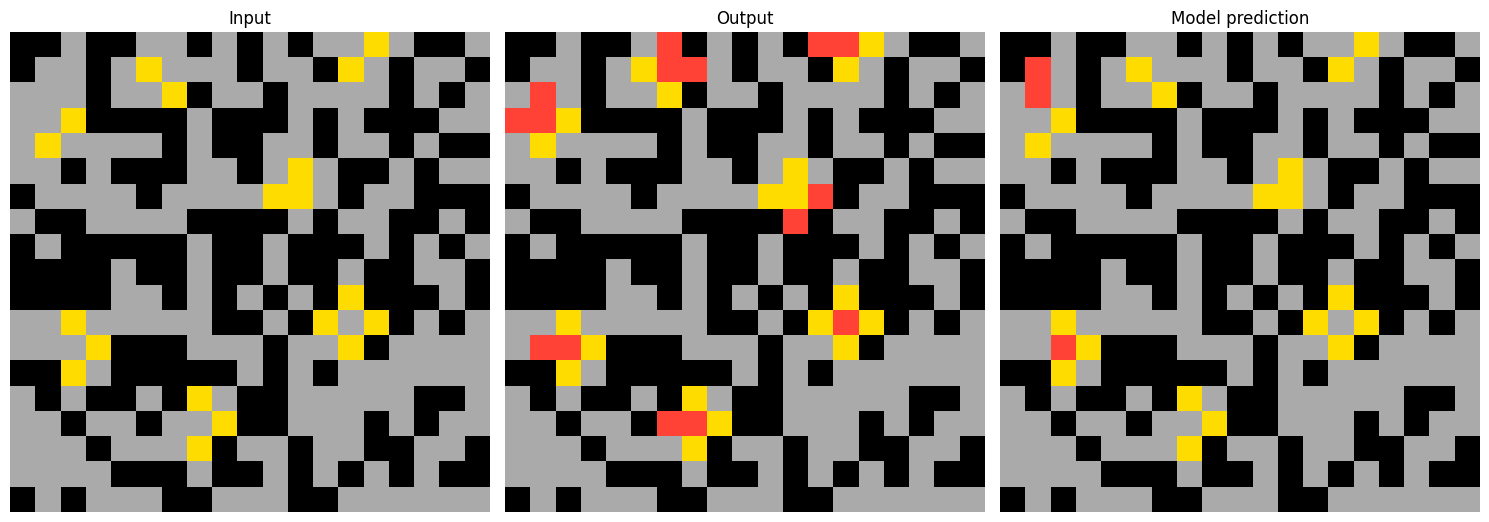

/Users/karankamath/Desktop/ARC-master/data/evaluation/4ff4c9da.json
4ff4c9da


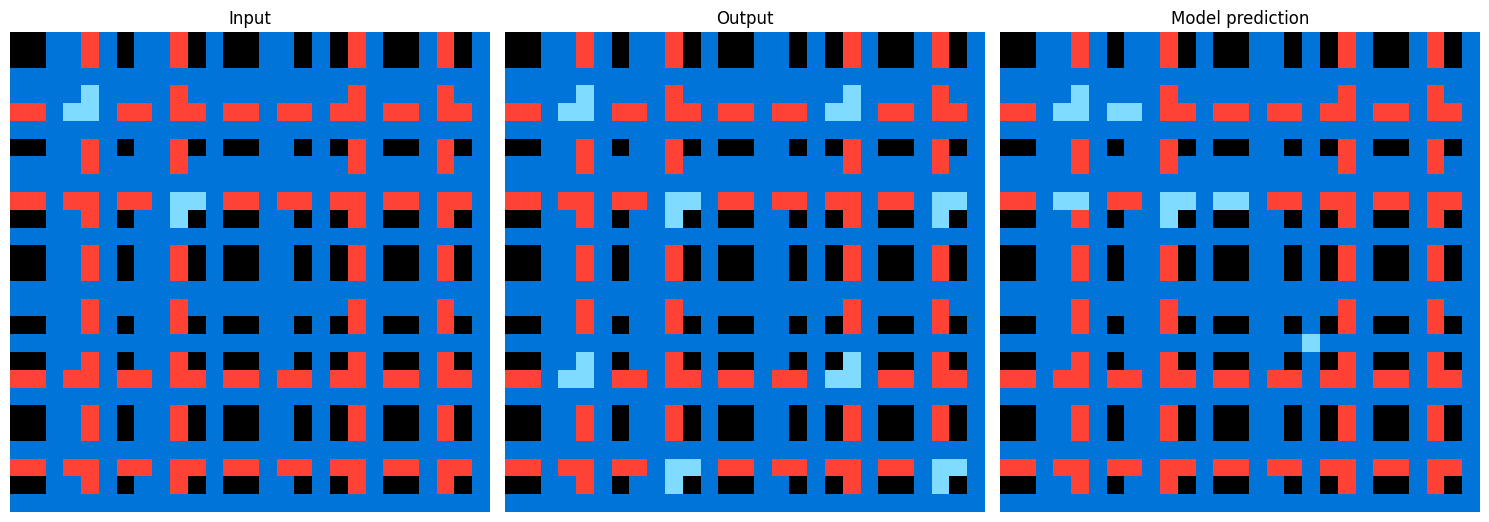

/Users/karankamath/Desktop/ARC-master/data/evaluation/f9d67f8b.json
f9d67f8b


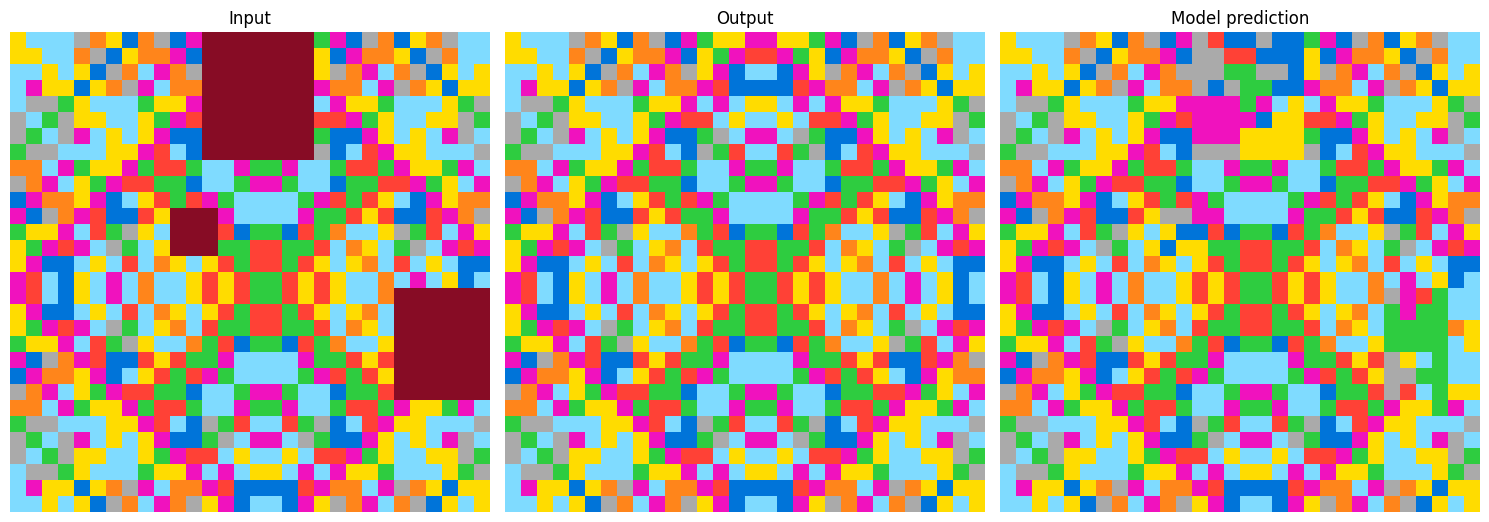

/Users/karankamath/Desktop/ARC-master/data/evaluation/5ffb2104.json
5ffb2104


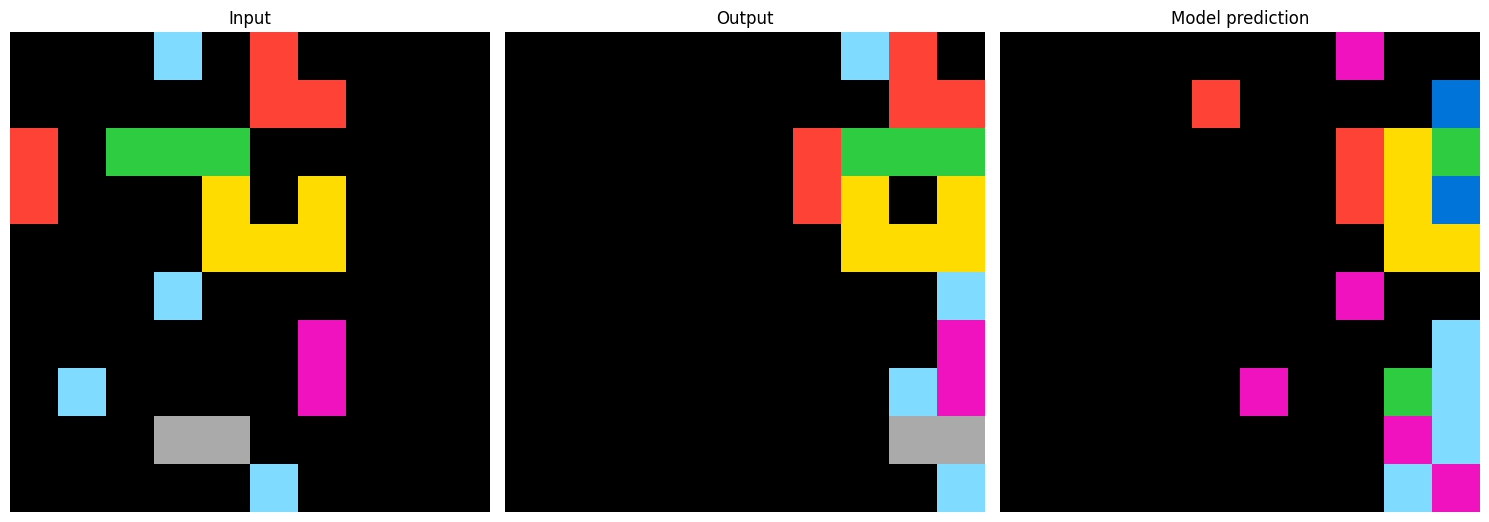

/Users/karankamath/Desktop/ARC-master/data/evaluation/2037f2c7.json
2037f2c7
/Users/karankamath/Desktop/ARC-master/data/evaluation/00dbd492.json
00dbd492


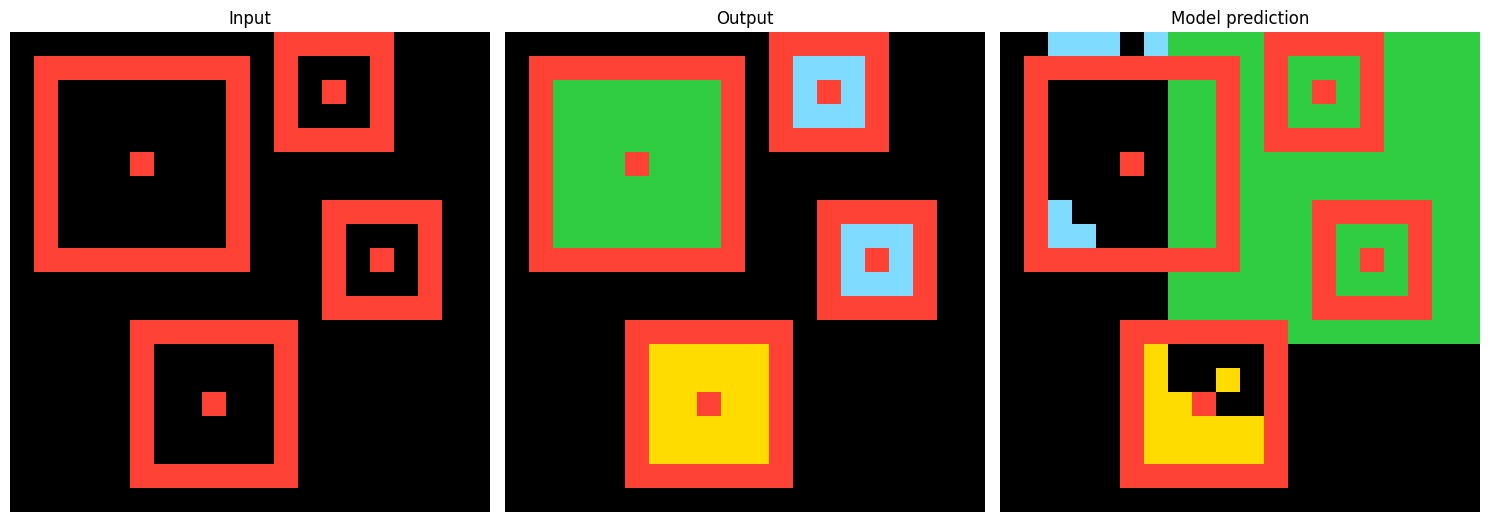

/Users/karankamath/Desktop/ARC-master/data/evaluation/9c1e755f.json
9c1e755f


KeyboardInterrupt: 

In [10]:
from sklearn.ensemble import VotingClassifier

def inp_oup_dim_same(task_json):
    return all([ len(pair["input"]) == len(pair["output"]) and len(pair["input"][0]) == len(pair["output"][0])
                for pair in task_json['train']])


solved_task = 0
total_task = 0
task_ids = []
task_preds = []

for task_path in test_path.glob("*.json"):
    print(task_path)
    task_json = json.load(open(task_path))
    tk_id = str(task_path).split("/")[-1].split(".")[0]
    print(tk_id)
    if(inp_oup_dim_same(task_json)):
        a_size = get_a_size(task_json)
        bl_cols = get_bl_cols(task_json)

        isflip = False
        X1,Y1 = gettaskxy(task_json,True,1,bl_cols,isflip)
        X3,Y3 = gettaskxy(task_json,True,3,bl_cols,isflip)
        X5,Y5 = gettaskxy(task_json,True,5,bl_cols,isflip)
        X7,Y7 = gettaskxy(task_json,True,7,bl_cols,isflip)
        # X9,Y9 = gettaskxy(task_json,True,9,bl_cols,isflip)

        model_1 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X1, Y1)
        model_3 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X3, Y3)
        model_5 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X5, Y5)
        model_7 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X7, Y7)
        # model_9 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X9, Y9)

         # pred_map_1 = submit_predict(task_json,model_1,1)
        # print("hi")
        # pred_map_3 = submit_predict(task_json,model_3,3)
        # pred_map_5 = submit_predict(task_json,model_5,5)
        # print("hi")
        # pred_map_7 = submit_predict(task_json,model_7,7)
        # pred_map_9 = submit_predict(task_json,model_9,9)
        # pred_map_13 = submit_predict(task_json,model_13,13)
        # print("hi")
        # pred_map_15 = submit_predict(task_json,model_15,19)
        # Create the ensemble model with voting
        ensemble_model_voting = VotingClassifier(estimators=[
            ('model_1', model_1),
            ('model_3', model_3),
            ('model_5', model_5),
            ('model_7', model_7)
            # ('model_9', model_9)
        ], voting='hard')  # 'hard' for majority voting
        # print("hi")

        # Train the ensemble model
        ensemble_model_voting.fit(X7, Y7)  # You can use any of the X, Y pairs here
        pred_map_9_new = submit_predict(task_json,ensemble_model_voting,7)

        # # Make predictions
        # ensemble_pred_voting = ensemble_model_voting.predict(X1)  # Again, any X can be used for prediction

        # # for tks,str_pred in combine_preds2(tk_id,pred_map_1,pred_map_3,pred_map_5,pred_map_7,pred_map_9,pred_map_13,pred_map_15):
        # for tks,str_pred in combine_preds1(tk_id,pred_map_1,pred_map_3,pred_map_5,pred_map_7,pred_map_9):
        #     task_ids.append(tks)
        #     task_preds.append(str_pred)
        #     #print(tks,str_pred)
        # solved_task+=1
    else:
        pred_map_1 = dumb_predict(task_json)
        pred_map_3 = dumb_predict(task_json)
        pred_map_5 = dumb_predict(task_json)

        for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5):
            task_ids.append(tks)
            task_preds.append(str_pred)
            #print(tks,str_pred)

    total_task+=1








# def inp_oup_dim_same(task_json):
#     return all([ len(pair["input"]) == len(pair["output"]) and len(pair["input"][0]) == len(pair["output"][0])
#                 for pair in task_json['train']])


# solved_task = 0
# total_task = 0
# task_ids = []
# task_preds = []

# for task_path in test_path.glob("*.json"):
#     print(task_path)
#     task_json = json.load(open(task_path))
#     tk_id = str(task_path).split("/")[-1].split(".")[0]
#     print(tk_id)
#     if(inp_oup_dim_same(task_json)):
#         a_size = get_a_size(task_json)
#         bl_cols = get_bl_cols(task_json)

#         isflip = False
#         X1,Y1 = gettaskxy(task_json,True,1,bl_cols,isflip)
#         X3,Y3 = gettaskxy(task_json,True,3,bl_cols,isflip)
#         X5,Y5 = gettaskxy(task_json,True,5,bl_cols,isflip)
#         X7,Y7 = gettaskxy(task_json,True,7,bl_cols,isflip)
#         X9,Y9 = gettaskxy(task_json,True,9,bl_cols,isflip)

#         model_1 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X1, Y1)
#         model_3 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X3, Y3)
#         model_5 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X5, Y5)
#         model_7 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X7, Y7)
#         model_9 = BaggingClassifier(estimator=DecisionTreeClassifier(),n_estimators=200).fit(X9, Y9)

#         pred_map_1 = submit_predict(task_json,model_1,1)
#         pred_map_3 = submit_predict(task_json,model_3,3)
#         pred_map_5 = submit_predict(task_json,model_5,5)
#         pred_map_7 = submit_predict(task_json,model_7,7)
#         pred_map_9 = submit_predict(task_json,model_9,9)

#         for tks,str_pred in combine_preds1(tk_id,pred_map_1,pred_map_3,pred_map_5,pred_map_7,pred_map_9):
#             task_ids.append(tks)
#             task_preds.append(str_pred)
#             #print(tks,str_pred)
#         solved_task+=1
#         #break
#     else:
#         pred_map_1 = dumb_predict(task_json)
#         pred_map_3 = dumb_predict(task_json)
#         pred_map_5 = dumb_predict(task_json)

#         for tks,str_pred in combine_preds(tk_id,pred_map_1,pred_map_3,pred_map_5):
#             task_ids.append(tks)
#             task_preds.append(str_pred)
#             #print(tks,str_pred)

#     total_task+=1
